# Guitar Classifier - Inference and Grad-CAM

rough draft, based on:  
https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam.ipynb
https://nbviewer.jupyter.org/github/MicPie/lung/blob/master/lung_fibrosis_v5_ResNet34_Grad-CAM.ipynb 


In [163]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [164]:
import fastai
from fastai import *
from fastai.vision import *
import numpy as np

import PIL

In [165]:
labels = (['fender_telecaster', 'gibson_les_paul', 'gibson_es', 
          'gibson_explorer', 'gibson_flying_v', 'fender_mustang', 
          'fender_stratocaster', 'gibson_sg', 'fender_jaguar', 
          'gibson_firebird', 'fender_jazzmaster'])

# lookup
names = {'fender_telecaster': "Fender Telecaster",
         'gibson_les_paul':   "Gibson Les Paul",
         'gibson_es':         "Gibson ES", 
         'gibson_explorer':   "Gibson Explorer",
         'gibson_flying_v':   "Gibson Flying V",
         'fender_mustang':    "Fender Mustang",
         'fender_stratocaster': 'Fender Stratocaster', 
         'gibson_sg':         "Gibson SG",
         'fender_jaguar':     "Fender Jaguar",
         'gibson_firebird':   "Gibson Firebird", 
         'fender_jazzmaster': "Fender Jazzmaster"}

In [166]:
MODEL = 'v0.1-stage-3-50.pth'

## Load and setup the model

In [167]:
path = Path("/tmp")
data = ImageDataBunch.single_from_classes(path, labels, tfms=get_transforms(max_warp=0.0), size=299).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet50)

target_layer = learn.model[0][-1][-1]

fmap_hook = fastai.callbacks.hook_output(target_layer)
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)

learn.model.eval();

learn.model.load_state_dict(
    torch.load("models/%s" % MODEL, map_location="cpu")
)

In [168]:
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [169]:
!ls testimages

animal-pet-cute-126407.jpg  K35721000001001-00-500x500.jpg
images-1.jpeg		    Stratocaster-vs-Les-Paul-Header.jpg
images.jpeg


In [226]:
fname = 'testimages/Stratocaster-vs-Les-Paul-Header.jpg'

In [227]:
img = open_image(fname)
pred_class, pred_idx, outputs = learn.predict(img)    

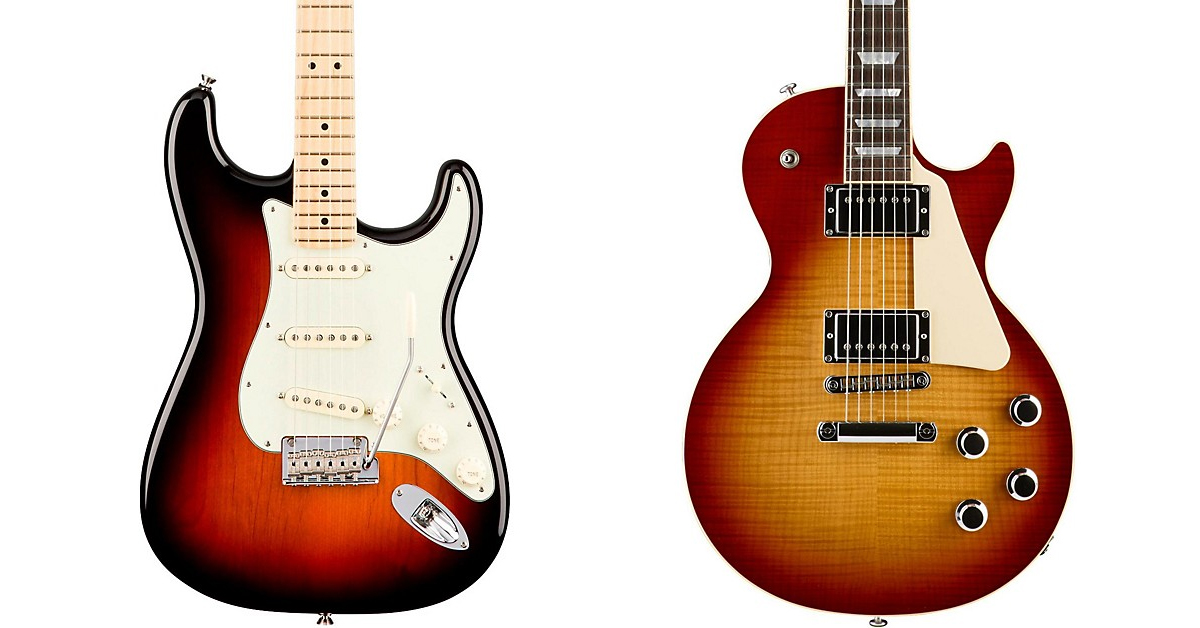

'gibson_les_paul'

tensor(1)

tensor([1.0597e+03, 1.4790e+03, 2.3765e+00, 3.1091e-02, 3.7352e-02, 8.4475e-02,
        3.8758e+01, 3.7386e-01, 3.6495e-02, 1.1332e-02, 1.2291e-01])

In [228]:
display(img); display(pred_class); display(pred_idx); display(outputs)

## convert image

In [229]:
learn.model.eval()

learn.data.valid_ds.set_item(img)


In [230]:
gradient_hook.stored

<generator object Hook.hook_fn.<locals>.<genexpr> at 0x7f2909622570>

## Try to produce CAM

In [231]:
upsampledL = []

tensor_img = list(learn.dl())[0][0]
out = learn.model(tensor_img); out

tensor([[ 6.9657,  7.2991,  0.8656, -3.4708, -3.2874, -2.4713,  3.6573, -0.9839,
         -3.3106, -4.4801, -2.0963]], device='cuda:0',
       grad_fn=<ThAddmmBackward>)

In [232]:
# argsort in reverse (negative tensor)
sort_idx = np.argsort(-out.cpu())[0]

from skimage.transform import resize
import scipy

vals_min = []
vals_max = []
for i in range(11):
    # get gradients for predicted class
    onehot = torch.zeros(data.c) # setup empty tensor based on number of classes

    onehot[i] = 1
    #onehot[torch.argmax(out)] = 1. # one-hot-encode predicted class
    out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True) # backpropagate onehot encoding to get gradients

    gradients = next(iter(gradient_hook.stored))
    gradient_linearization = gradients.cpu().numpy().sum((2,3)).reshape(-1) # sum up gradients and linearize
    
    _, n, w, h = gradients.shape

    fmaps = fmap_hook.stored.cpu().numpy().reshape(n, w, h) # reshape activations
    heatmap = np.maximum(0, np.einsum('i, ijk', gradient_linearization, fmaps)) # multiply summed gradients with the gradients to get the heatmap
    
    heatmap_299 = scipy.ndimage.interpolation.zoom(heatmap, (299/10, 299/10), order=3)
    print(heatmap_299.shape)
    upsampledL.append(heatmap_299)


        

(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)
(299, 299)


In [233]:
import matplotlib.colors as c
cmapIn = plt.get_cmap('hot_r')

minval = 0
maxval = 0.9
new_cmap = c.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
    cmapIn(np.linspace(minval, maxval, n)))

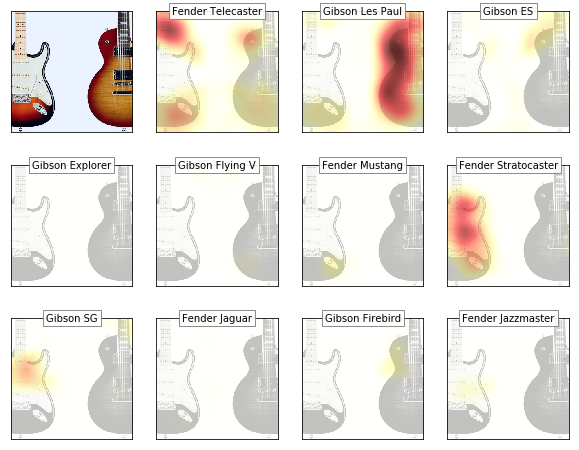

In [242]:
t = np.transpose(tensor_img.squeeze(), (1, 2, 0))
t = (t - t.min()) / (t.max() - t.min())


fig, axes = plt.subplots(3, 4, figsize=(10,8))

min_all = min([x.min() for x in upsampledL])
max_all = max([x.max() for x in upsampledL])

bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=0.9)


# iterate over all classes and plot grad-CAM for each
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(t.numpy())
    else:
        ax.imshow(t[...,2], cmap="Greys_r", alpha=.25)

        up = (upsampledL[i-1][...,np.newaxis]-min_all) / max_all
        colors = new_cmap((upsampledL[i-1]-min_all) / max_all)

        # set alpha
        colors[..., -1] = up.squeeze() * 0.75 
        ax.imshow(colors)
        
        lab = names[labels[i-1]]
        ax.text(150, 0, lab, ha="center", va="center", size=10, bbox=bbox_props)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.savefig('cam.png', bbox_inches='tight')

In [241]:
!ls

cam.png				 inference_gradcam.ipynb
guitars1.ipynb			 lung_fibrosis_v5_ResNet34_Grad-CAM.ipynb
inference_and_gradcam_bad.ipynb  models
inference_and_gradcam.ipynb	 mydata
inference_gradcam-Copy1.ipynb	 testimages
